In [1]:
import torch

print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'CUDA version: {torch.version.cuda}')
    print(f'GPU device: {torch.cuda.get_device_name(0)}')
    print(f'Number of GPUs: {torch.cuda.device_count()}')
else:
    print('CUDA not available - GPU support not working')


PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU device: NVIDIA GeForce RTX 3060 Laptop GPU
Number of GPUs: 1


# Tumor Detector (Completed)

Complete CNN/FasterRCNN/YOLOv8 training + validation notebook.


## 1. Environment
Install deps (PyTorch/torchvision, YAML, Pillow, optional ultralytics for YOLOv8).


In [2]:
# # %pip install -q torch torchvision pyyaml pillow
# %pip install -q pyyaml pillow
# # Uncomment for YOLOv8
# %pip install -q ultralytics
print("done")

done


## 2. Paths and config
Set dataset locations and training hyperparameters. Adjust to your Task01-processed PNGs and JSONs.


In [3]:
import sys
from pathlib import Path
import yaml
import torch

# Add project root so `models` imports work
PROJECT_ROOT = Path.cwd().resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Update these to your data
image_root = Path("data/processed")  # folder with PNG/JPG slices
train_annotations = Path("data/annotations/train.json")
val_annotations = Path("data/annotations/val.json")

default_labels = ["No Tumor", "Glioma", "Meningioma", "Pituitary"]

config = {
    "experiment_name": "detector_complete",
    "task": "detection",  # 'classification' or 'detection'
    "model": {
        "name": "fasterrcnn_resnet50_fpn",  # or resnet18 for classification
        "pretrained": True,
    },
    "data": {
        "image_root": str(image_root),
        "train_annotations": str(train_annotations),
        "val_annotations": str(val_annotations),
        "labels": default_labels,
    },
    "train": {
        "epochs": 5,
        "batch_size": 2,
        "lr": 2e-4,
        "weight_decay": 5e-4,
        "num_workers": 2,
        "grad_clip": 1.0,
        "checkpoint_dir": "runs/detector",
        "save_every": 1,
    },
}

# Save a copy of the config for reference
Path("configs").mkdir(parents=True, exist_ok=True)
with open("configs/detector_completed.yaml", "w", encoding="utf-8") as f:
    yaml.safe_dump(config, f)

config



{'experiment_name': 'detector_complete',
 'task': 'detection',
 'model': {'name': 'fasterrcnn_resnet50_fpn', 'pretrained': True},
 'data': {'image_root': 'data\\processed',
  'train_annotations': 'data\\annotations\\train.json',
  'val_annotations': 'data\\annotations\\val.json',
  'labels': ['No Tumor', 'Glioma', 'Meningioma', 'Pituitary']},
 'train': {'epochs': 5,
  'batch_size': 2,
  'lr': 0.0002,
  'weight_decay': 0.0005,
  'num_workers': 2,
  'grad_clip': 1.0,
  'checkpoint_dir': 'runs/detector',
  'save_every': 1}}

In [4]:
# Ensure repo root (with `models/`) is on sys.path
import sys
from pathlib import Path

# Try current directory, then walk up to find 'models'
root = Path.cwd().resolve()
if not (root / "models").exists():
    for parent in root.parents:
        if (parent / "models").exists():
            root = parent
            break

if str(root) not in sys.path:
    sys.path.insert(0, str(root))

# Override data paths to be absolute from project root
image_root = root / "data/processed"
train_annotations = root / "data/annotations/train.json"
val_annotations = root / "data/annotations/val.json"
config["data"].update(
    {
        "image_root": str(image_root),
        "train_annotations": str(train_annotations),
        "val_annotations": str(val_annotations),
    }
)

print("Using project root for imports:", root)
print("models exists:", (root / "models").exists())
print("Image root:", image_root)
print("Train annotations:", train_annotations)
print("Val annotations:", val_annotations)


Using project root for imports: C:\Users\FERRA\OneDrive\Documents\github\BT-pipe
models exists: True
Image root: C:\Users\FERRA\OneDrive\Documents\github\BT-pipe\data\processed
Train annotations: C:\Users\FERRA\OneDrive\Documents\github\BT-pipe\data\annotations\train.json
Val annotations: C:\Users\FERRA\OneDrive\Documents\github\BT-pipe\data\annotations\val.json


## Task01 converter (NIfTI → PNG + JSON)
Run once to generate `data/processed/*.png` and `data/annotations/train.json` / `val.json` from BRATS Task01 volumes.


In [5]:
# %pip install -q nibabel scikit-learn


In [6]:
import json
import numpy as np
import nibabel as nib
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split

# Paths to your Task01 BRATS data (use project root)
img_dir = root / "Data/Task01_BrainTumour/imagesTr"
lbl_dir = root / "Data/Task01_BrainTumour/labelsTr"

# Output locations for slices and annotations (absolute)
out_images = root / "data/processed"
out_ann = root / "data/annotations"
out_images.mkdir(parents=True, exist_ok=True)
out_ann.mkdir(parents=True, exist_ok=True)

# Label list for config; using single-class "Glioma" here
label_name = "Glioma"

# Quick sanity checks - filter out macOS resource fork files
img_files = [f for f in sorted(img_dir.glob("*.nii.gz")) if not f.name.startswith("._")]
lbl_files = [f for f in sorted(lbl_dir.glob("*.nii.gz")) if not f.name.startswith("._")]
# Also check for .nii files (without .gz)
img_files_nii = [f for f in sorted(img_dir.glob("*.nii")) if not f.name.startswith("._") and not f.name.endswith(".gz")]
lbl_files_nii = [f for f in sorted(lbl_dir.glob("*.nii")) if not f.name.startswith("._") and not f.name.endswith(".gz")]
img_files.extend(img_files_nii)
lbl_files.extend(lbl_files_nii)

print("Found images:", len(img_files), "labels:", len(lbl_files))
if not img_files:
    raise RuntimeError("No image volumes found at " + str(img_dir))
if not lbl_files:
    raise RuntimeError("No label volumes found at " + str(lbl_dir))

def get_case_name(path: Path) -> str:
    """Extract case name from BRATS file, handling both .nii and .nii.gz"""
    name = path.name
    if name.endswith(".nii.gz"):
        return name[:-7]  # Remove .nii.gz
    elif name.endswith(".nii"):
        return name[:-4]  # Remove .nii
    return path.stem

samples = []
for img_path in img_files:
    case = get_case_name(img_path)
    # Try both .nii.gz and .nii extensions
    lbl_path = lbl_dir / f"{case}.nii.gz"
    if not lbl_path.exists():
        lbl_path = lbl_dir / f"{case}.nii"
    if not lbl_path.exists():
        print(f"Skipping {case}, missing label file (tried {case}.nii.gz and {case}.nii)")
        continue
    img_vol = nib.load(img_path).get_fdata()
    lbl_vol = nib.load(lbl_path).get_fdata()

    # Use the first modality channel if 4D
    if img_vol.ndim == 4:
        img_vol = img_vol[..., 0]

    # Count non-empty slices for this case
    non_empty = int(np.sum(lbl_vol.max(axis=(0, 1)) > 0))
    if non_empty == 0:
        print(f"All-empty label volume: {case}")
        continue
    else:
        print(f"{case}: {non_empty} non-empty slices")

    for z in range(img_vol.shape[2]):
        lbl_slice = lbl_vol[..., z]
        if lbl_slice.max() < 1:  # skip empty slices
            continue
        ys, xs = np.where(lbl_slice > 0)
        x1, x2 = xs.min(), xs.max()
        y1, y2 = ys.min(), ys.max()

        # Validate bounding box: ensure it has positive width and height
        width = x2 - x1
        height = y2 - y1
        if width <= 0 or height <= 0:
            continue  # Skip invalid bounding boxes

        img_slice = img_vol[..., z]
        # normalize to 0-255
        arr = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min() + 1e-8)
        arr = (arr * 255).clip(0, 255).astype(np.uint8)

        png_name = f"{case}_z{z:03d}.png"
        Image.fromarray(arr).save(out_images / png_name)

        samples.append(
            {
                "image": png_name,
                "label": label_name,
                "bbox": [int(x1), int(y1), int(x2), int(y2)],
            }
        )

print("Total slices with tumors:", len(samples))

if len(samples) == 0:
    raise RuntimeError(
        "No labeled slices were found. Check that nibabel can read your label "
        "volumes and that `labelsTr` contains non-empty masks."
    )

# Train/val split
train, val = train_test_split(samples, test_size=0.2, random_state=42)
with open(out_ann / "train.json", "w", encoding="utf-8") as f:
    json.dump(train, f)
with open(out_ann / "val.json", "w", encoding="utf-8") as f:
    json.dump(val, f)

print("Wrote", len(train), "train and", len(val), "val samples")


Found images: 484 labels: 484
BRATS_001: 74 non-empty slices
BRATS_002: 61 non-empty slices
BRATS_003: 82 non-empty slices
BRATS_004: 73 non-empty slices
BRATS_005: 76 non-empty slices
BRATS_006: 84 non-empty slices
BRATS_007: 58 non-empty slices
BRATS_008: 76 non-empty slices
BRATS_009: 74 non-empty slices
BRATS_010: 41 non-empty slices
BRATS_011: 66 non-empty slices
BRATS_012: 44 non-empty slices
BRATS_013: 36 non-empty slices
BRATS_014: 72 non-empty slices
BRATS_015: 81 non-empty slices
BRATS_016: 57 non-empty slices
BRATS_017: 60 non-empty slices
BRATS_018: 76 non-empty slices
BRATS_019: 97 non-empty slices
BRATS_020: 80 non-empty slices
BRATS_021: 48 non-empty slices
BRATS_022: 80 non-empty slices
BRATS_023: 57 non-empty slices
BRATS_024: 41 non-empty slices
BRATS_025: 33 non-empty slices
BRATS_026: 56 non-empty slices
BRATS_027: 49 non-empty slices
BRATS_028: 53 non-empty slices
BRATS_029: 27 non-empty slices
BRATS_030: 44 non-empty slices
BRATS_031: 58 non-empty slices
BRATS_032

## 3. Data loaders
Uses the repo dataset utilities.


In [7]:
import json, os
from pathlib import Path
import nibabel as nib
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Use project root from cell 5 (ensure it's defined)
try:
    # root should be defined from cell 5
    pass
except NameError:
    # Fallback if cell 5 wasn't run
    root = Path.cwd().resolve()
    if not (root / "models").exists():
        for parent in root.parents:
            if (parent / "models").exists():
                root = parent
                break

img_dir = root / "Data/Task01_BrainTumour/imagesTr"
lbl_dir = root / "Data/Task01_BrainTumour/labelsTr"
out_images = root / "data/processed"
out_ann = root / "data/annotations"
out_images.mkdir(parents=True, exist_ok=True)
out_ann.mkdir(parents=True, exist_ok=True)

# Filter out macOS resource fork files and handle both .nii and .nii.gz
img_files = [f for f in sorted(img_dir.glob("*.nii.gz")) if not f.name.startswith("._")]
img_files_nii = [f for f in sorted(img_dir.glob("*.nii")) if not f.name.startswith("._") and not f.name.endswith(".gz")]
img_files.extend(img_files_nii)

# Get label files too
lbl_files = [f for f in sorted(lbl_dir.glob("*.nii.gz")) if not f.name.startswith("._")]
lbl_files_nii = [f for f in sorted(lbl_dir.glob("*.nii")) if not f.name.startswith("._") and not f.name.endswith(".gz")]
lbl_files.extend(lbl_files_nii)

print(f"Found {len(img_files)} image files and {len(lbl_files)} label files")
print(f"Image dir: {img_dir}")
print(f"Label dir: {lbl_dir}")
if img_files:
    print(f"First image file: {img_files[0].name}")
if lbl_files:
    print(f"First label file: {lbl_files[0].name}")

def get_case_name(path: Path) -> str:
    """Extract case name from BRATS file, handling both .nii and .nii.gz"""
    name = path.name
    if name.endswith(".nii.gz"):
        return name[:-7]  # Remove .nii.gz
    elif name.endswith(".nii"):
        return name[:-4]  # Remove .nii
    return path.stem

# Create a set of available label case names for faster lookup
available_label_cases = {get_case_name(f) for f in lbl_files}
print(f"Available label cases (first 10): {sorted(list(available_label_cases))[:10]}")

samples = []
matched = 0
skipped_no_label = 0
skipped_empty = 0

for img_path in img_files:
    case = get_case_name(img_path)
    # Try both .nii.gz and .nii extensions
    lbl_path = lbl_dir / f"{case}.nii.gz"
    if not lbl_path.exists():
        lbl_path = lbl_dir / f"{case}.nii"
    if not lbl_path.exists():
        skipped_no_label += 1
        if skipped_no_label <= 5:  # Show first 5 mismatches
            print(f"  No label found for {case} (tried {case}.nii.gz and {case}.nii)")
        continue
    matched += 1
    img_vol = nib.load(img_path).get_fdata()
    lbl_vol = nib.load(lbl_path).get_fdata()
    # use one modality (e.g., FLAIR channel 0); adjust if needed
    if img_vol.ndim == 4:
        img_vol = img_vol[..., 0]

    # Check if this volume has any non-empty slices
    has_tumors = lbl_vol.max() > 0
    if not has_tumors:
        skipped_empty += 1
        continue

    for z in range(img_vol.shape[2]):
        img_slice = img_vol[..., z]
        lbl_slice = lbl_vol[..., z]
        if lbl_slice.max() < 1:  # skip empty
            continue
        ys, xs = np.where(lbl_slice > 0)
        x1, x2 = xs.min(), xs.max()
        y1, y2 = ys.min(), ys.max()
        
        # Validate bounding box: ensure it has positive width and height
        width = x2 - x1
        height = y2 - y1
        if width <= 0 or height <= 0:
            continue  # Skip invalid bounding boxes
        
        # normalize to 0-255
        arr = img_slice
        arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
        arr = (arr * 255).clip(0, 255).astype(np.uint8)
        png_name = f"{case}_z{z:03d}.png"
        Image.fromarray(arr).save(out_images / png_name)
        samples.append({
            "image": png_name,
            "label": "Glioma",           # set your class name
            "bbox": [int(x1), int(y1), int(x2), int(y2)],
        })

print(f"\nSummary:")
print(f"  Matched image-label pairs: {matched}")
print(f"  Skipped (no label file): {skipped_no_label}")
print(f"  Skipped (empty label volume): {skipped_empty}")
print(f"  Total slices with tumors: {len(samples)}")

if len(samples) == 0:
    print(f"\nDebugging info:")
    print(f"  Image files found: {len(img_files)}")
    print(f"  Label files found: {len(lbl_files)}")
    if img_files and lbl_files:
        img_case = get_case_name(img_files[0])
        lbl_case = get_case_name(lbl_files[0])
        print(f"  First image case: '{img_case}'")
        print(f"  First label case: '{lbl_case}'")
        print(f"  Do they match? {img_case == lbl_case}")
    raise RuntimeError(
        "No labeled slices were found. Check that nibabel can read your label "
        "volumes and that `labelsTr` contains non-empty masks."
    )

# split train/val
train, val = train_test_split(samples, test_size=0.2, random_state=42)
json.dump(train, open(out_ann / "train.json", "w"))
json.dump(val, open(out_ann / "val.json", "w"))
print("Wrote", len(train), "train and", len(val), "val samples")

Found 484 image files and 484 label files
Image dir: C:\Users\FERRA\OneDrive\Documents\github\BT-pipe\Data\Task01_BrainTumour\imagesTr
Label dir: C:\Users\FERRA\OneDrive\Documents\github\BT-pipe\Data\Task01_BrainTumour\labelsTr
First image file: BRATS_001.nii.gz
First label file: BRATS_001.nii.gz
Available label cases (first 10): ['BRATS_001', 'BRATS_002', 'BRATS_003', 'BRATS_004', 'BRATS_005', 'BRATS_006', 'BRATS_007', 'BRATS_008', 'BRATS_009', 'BRATS_010']

Summary:
  Matched image-label pairs: 484
  Skipped (no label file): 0
  Skipped (empty label volume): 0
  Total slices with tumors: 33438
Wrote 26750 train and 6688 val samples


In [8]:
from models.detector import TumorDataset, detection_collate_fn, build_model
from models.detector.dataset import _build_transforms
from torch.utils.data import DataLoader

# Resolve paths and verify that annotation files exist
from pathlib import Path

def _resolve_with_fallback(p: Path) -> Path:
    """Resolve a path; if missing, search parents for a matching relative path."""
    p = p.expanduser()
    if p.is_absolute():
        if p.exists():
            return p
        # If absolute but under notebooks/, try parent project
        candidates = [p, Path.cwd().resolve().parent / p.relative_to(p.anchor)] if "notebooks" in str(p) else [p]
    else:
        candidates = [Path.cwd() / p]
    # Walk up parents to find matching relative location
    rel = p.name if p.is_absolute() else p
    for base in [Path.cwd()] + list(Path.cwd().parents):
        candidate = base / rel
        candidates.append(candidate)
    for c in candidates:
        try:
            if c.exists():
                return c.resolve()
        except OSError:
            continue
    return p.resolve()

train_ann = _resolve_with_fallback(Path(config["data"]["train_annotations"]))
val_ann = _resolve_with_fallback(Path(config["data"]["val_annotations"]))
img_root = _resolve_with_fallback(Path(config["data"]["image_root"]))
config["data"].update(
    {
        "train_annotations": str(train_ann),
        "val_annotations": str(val_ann),
        "image_root": str(img_root),
    }
)

for p, label in [(train_ann, "train"), (val_ann, "val")]:
    if not p.exists():
        raise FileNotFoundError(
            f"Missing {label} annotations at {p}. Run the converter cell (Task01 -> PNG/JSON) to generate them."
        )
if not img_root.exists():
    raise FileNotFoundError(
        f"Image root not found at {img_root}. Ensure the converter wrote PNGs there."
    )

# Build datasets
train_ds = TumorDataset(
    annotation_path=str(train_ann),
    image_root=str(img_root),
    labels=config["data"]["labels"],
    task=config["task"],
    transforms=_build_transforms(config["task"], is_train=True),
)
val_ds = TumorDataset(
    annotation_path=str(val_ann),
    image_root=str(img_root),
    labels=config["data"]["labels"],
    task=config["task"],
    transforms=_build_transforms(config["task"], is_train=False),
)

collate_fn = detection_collate_fn if config["task"] == "detection" else None

# Fix for Windows/CUDA compatibility: num_workers > 0 can cause stream mismatch errors
# On Windows with CUDA, set num_workers to 0 to avoid cuDNN stream errors
import platform
num_workers = config["train"]["num_workers"]
if platform.system() == "Windows" and torch.cuda.is_available():
    num_workers = 0
    print("Note: Setting num_workers=0 for Windows/CUDA compatibility to avoid stream mismatch errors")

train_loader = DataLoader(
    train_ds,
    batch_size=config["train"]["batch_size"],
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True if torch.cuda.is_available() else False,  # Helps with GPU transfer
)
val_loader = DataLoader(
    val_ds,
    batch_size=config["train"]["batch_size"],
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True if torch.cuda.is_available() else False,
)

print(f"Train samples: {len(train_ds)} | Val samples: {len(val_ds)}")
print("Sample[0] keys:", train_ds.samples[0].keys())

Note: Setting num_workers=0 for Windows/CUDA compatibility to avoid stream mismatch errors
Train samples: 26750 | Val samples: 6688
Sample[0] keys: dict_keys(['image', 'label', 'bbox'])


## 4. Build model


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(config["data"]["labels"])
model = build_model(
    task=config["task"],
    num_classes=num_classes,
    model_name=config["model"]["name"],
    pretrained=config["model"]["pretrained"],
).to(device)
print(f"Model: {config['model']['name']} | Task: {config['task']} | Device: {device}")


Model: fasterrcnn_resnet50_fpn | Task: detection | Device: cuda


## 5. Training + validation
Lightweight loop for both classification (acc/F1) and detection (loss proxy).


  Batch 100/13375, Loss: 0.2154
  Batch 200/13375, Loss: 0.2678
  Batch 300/13375, Loss: 0.2118
  Batch 400/13375, Loss: 0.5751
  Batch 500/13375, Loss: 0.2579
  Batch 600/13375, Loss: 0.2296
  Batch 700/13375, Loss: 0.2495
  Batch 800/13375, Loss: 0.2335
  Batch 900/13375, Loss: 0.2557
  Batch 1000/13375, Loss: 0.5236
  Batch 1100/13375, Loss: 0.2299
  Batch 1200/13375, Loss: 0.1501
  Batch 1300/13375, Loss: 0.1326
  Batch 1400/13375, Loss: 0.2443
  Batch 1500/13375, Loss: 0.1822
  Batch 1600/13375, Loss: 0.3165
  Batch 1700/13375, Loss: 0.2854
  Batch 1800/13375, Loss: 0.1377
  Batch 1900/13375, Loss: 0.7288
  Batch 2000/13375, Loss: 0.3035
  Batch 2100/13375, Loss: 0.1900
  Batch 2200/13375, Loss: 0.1448
  Batch 2300/13375, Loss: 0.2353
  Batch 2400/13375, Loss: 0.1365
  Batch 2500/13375, Loss: 0.5980
  Batch 2600/13375, Loss: 0.1507
  Batch 2700/13375, Loss: 1.1971
  Batch 2800/13375, Loss: 0.1490
  Batch 2900/13375, Loss: 0.2317
  Batch 3000/13375, Loss: 0.2132
  Batch 3100/13375,

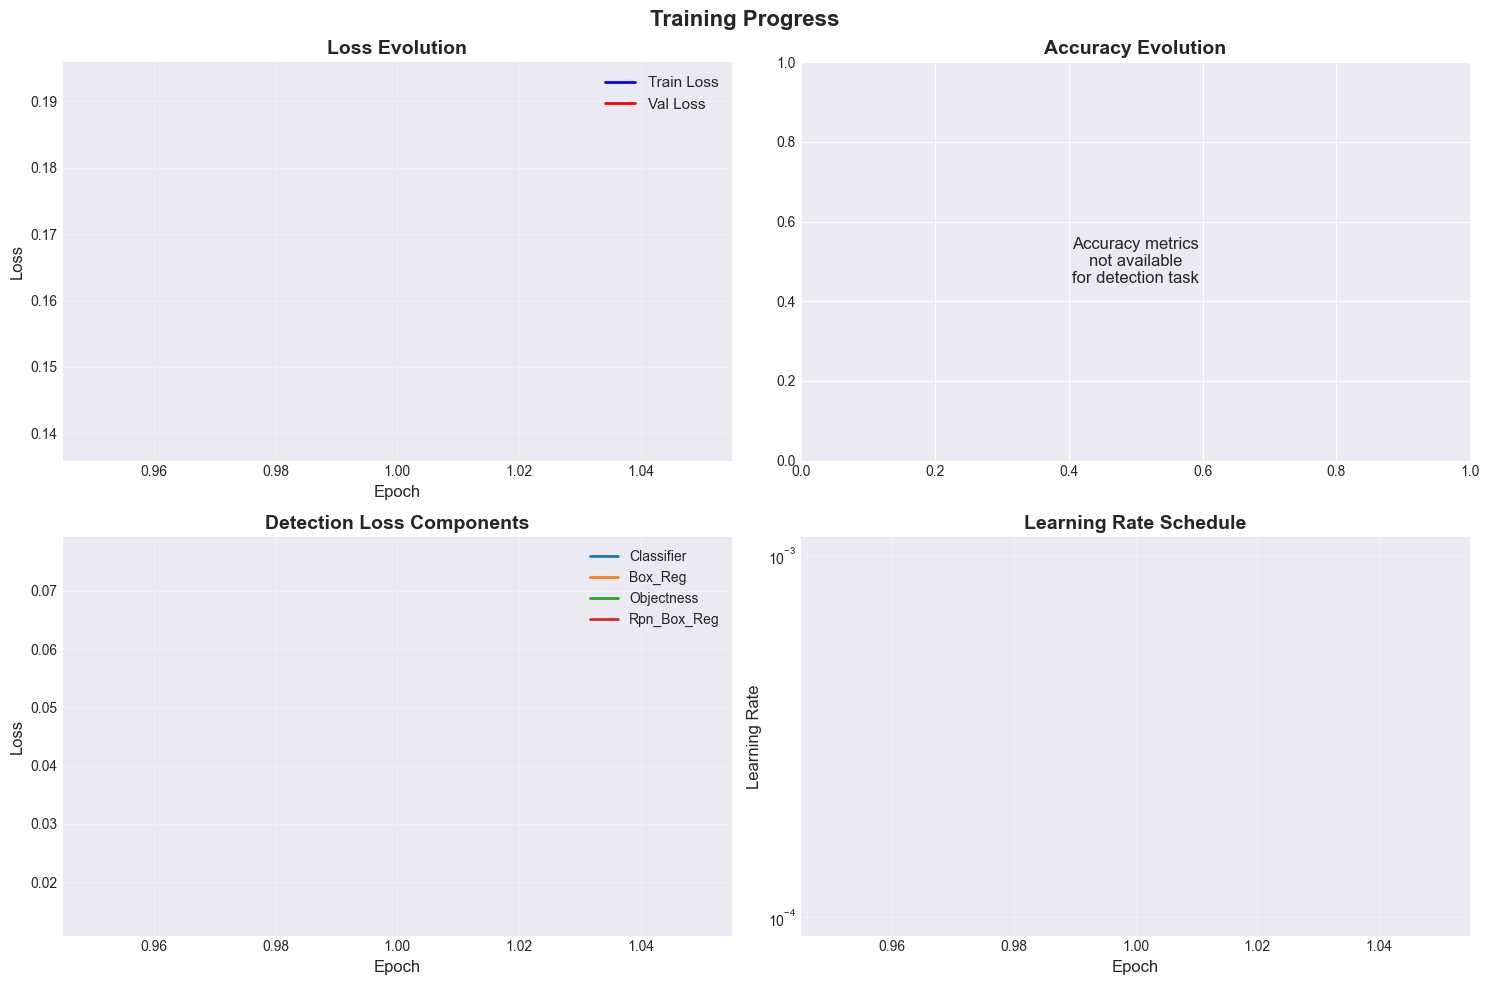

  Batch 100/13375, Loss: 0.1558
  Batch 200/13375, Loss: 0.2260
  Batch 300/13375, Loss: 0.1371
  Batch 400/13375, Loss: 0.1528
  Batch 500/13375, Loss: 0.1297
  Batch 600/13375, Loss: 0.0867
  Batch 700/13375, Loss: 0.1163
  Batch 800/13375, Loss: 0.1460
  Batch 900/13375, Loss: 0.1813
  Batch 1000/13375, Loss: 0.1406
  Batch 1100/13375, Loss: 0.1362
  Batch 1200/13375, Loss: 0.1531
  Batch 1300/13375, Loss: 0.1440
  Batch 1400/13375, Loss: 0.1490
  Batch 1500/13375, Loss: 0.1476
  Batch 1600/13375, Loss: 0.1445
  Batch 1700/13375, Loss: 0.1431
  Batch 1800/13375, Loss: 0.1820
  Batch 1900/13375, Loss: 0.0958
  Batch 2000/13375, Loss: 0.1218
  Batch 2100/13375, Loss: 0.1854
  Batch 2200/13375, Loss: 0.1746
  Batch 2300/13375, Loss: 0.1077
  Batch 2400/13375, Loss: 0.1577
  Batch 2500/13375, Loss: 0.0492
  Batch 2600/13375, Loss: 0.1360
  Batch 2700/13375, Loss: 0.1493
  Batch 2800/13375, Loss: 0.1274
  Batch 2900/13375, Loss: 0.1800
  Batch 3000/13375, Loss: 0.0963
  Batch 3100/13375,

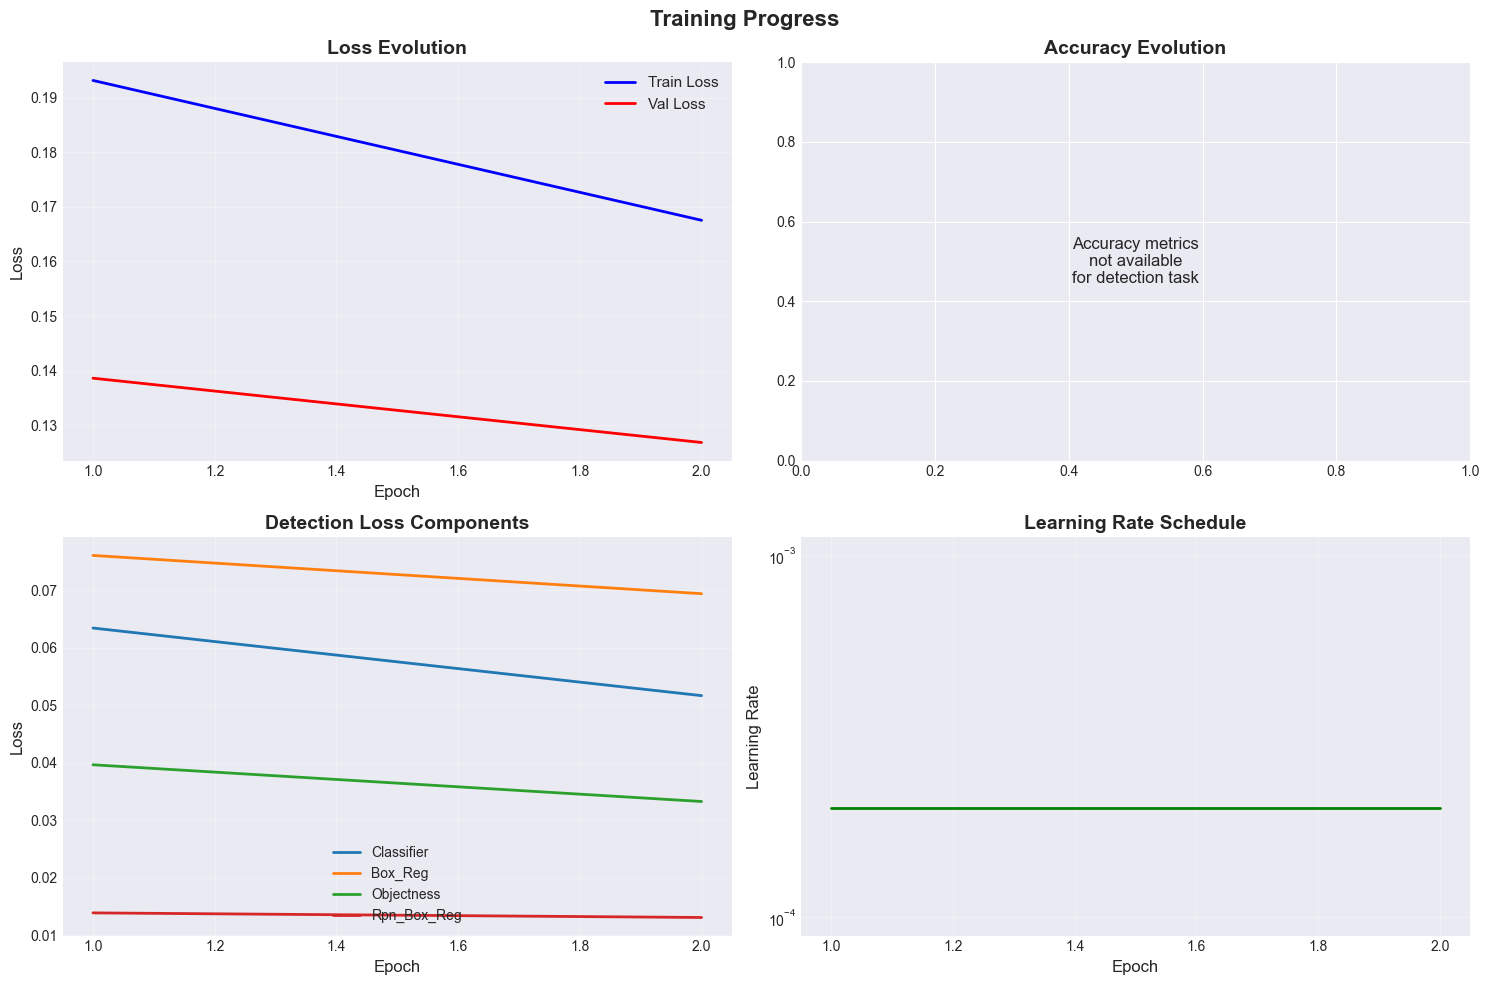

  Batch 100/13375, Loss: 0.1903
  Batch 200/13375, Loss: 0.2334
  Batch 300/13375, Loss: 0.1533
  Batch 400/13375, Loss: 0.1057
  Batch 500/13375, Loss: 0.1315
  Batch 600/13375, Loss: 0.2055
  Batch 700/13375, Loss: 0.2486
  Batch 800/13375, Loss: 0.1622
  Batch 900/13375, Loss: 0.0748
  Batch 1000/13375, Loss: 0.1500
  Batch 1100/13375, Loss: 0.1630
  Batch 1200/13375, Loss: 0.0829
  Batch 1300/13375, Loss: 0.1642
  Batch 1400/13375, Loss: 0.1457
  Batch 1500/13375, Loss: 0.1237
  Batch 1600/13375, Loss: 0.0725
  Batch 1700/13375, Loss: 0.1187
  Batch 1800/13375, Loss: 0.1351
  Batch 1900/13375, Loss: 0.2023
  Batch 2000/13375, Loss: 0.0946
  Batch 2100/13375, Loss: 0.1818
  Batch 2200/13375, Loss: 0.1742
  Batch 2300/13375, Loss: 0.1307
  Batch 2400/13375, Loss: 0.1181
  Batch 2500/13375, Loss: 0.2618
  Batch 2600/13375, Loss: 0.0955
  Batch 2700/13375, Loss: 0.0952
  Batch 2800/13375, Loss: 1.3285
  Batch 2900/13375, Loss: 0.1707
  Batch 3000/13375, Loss: 0.1189
  Batch 3100/13375,

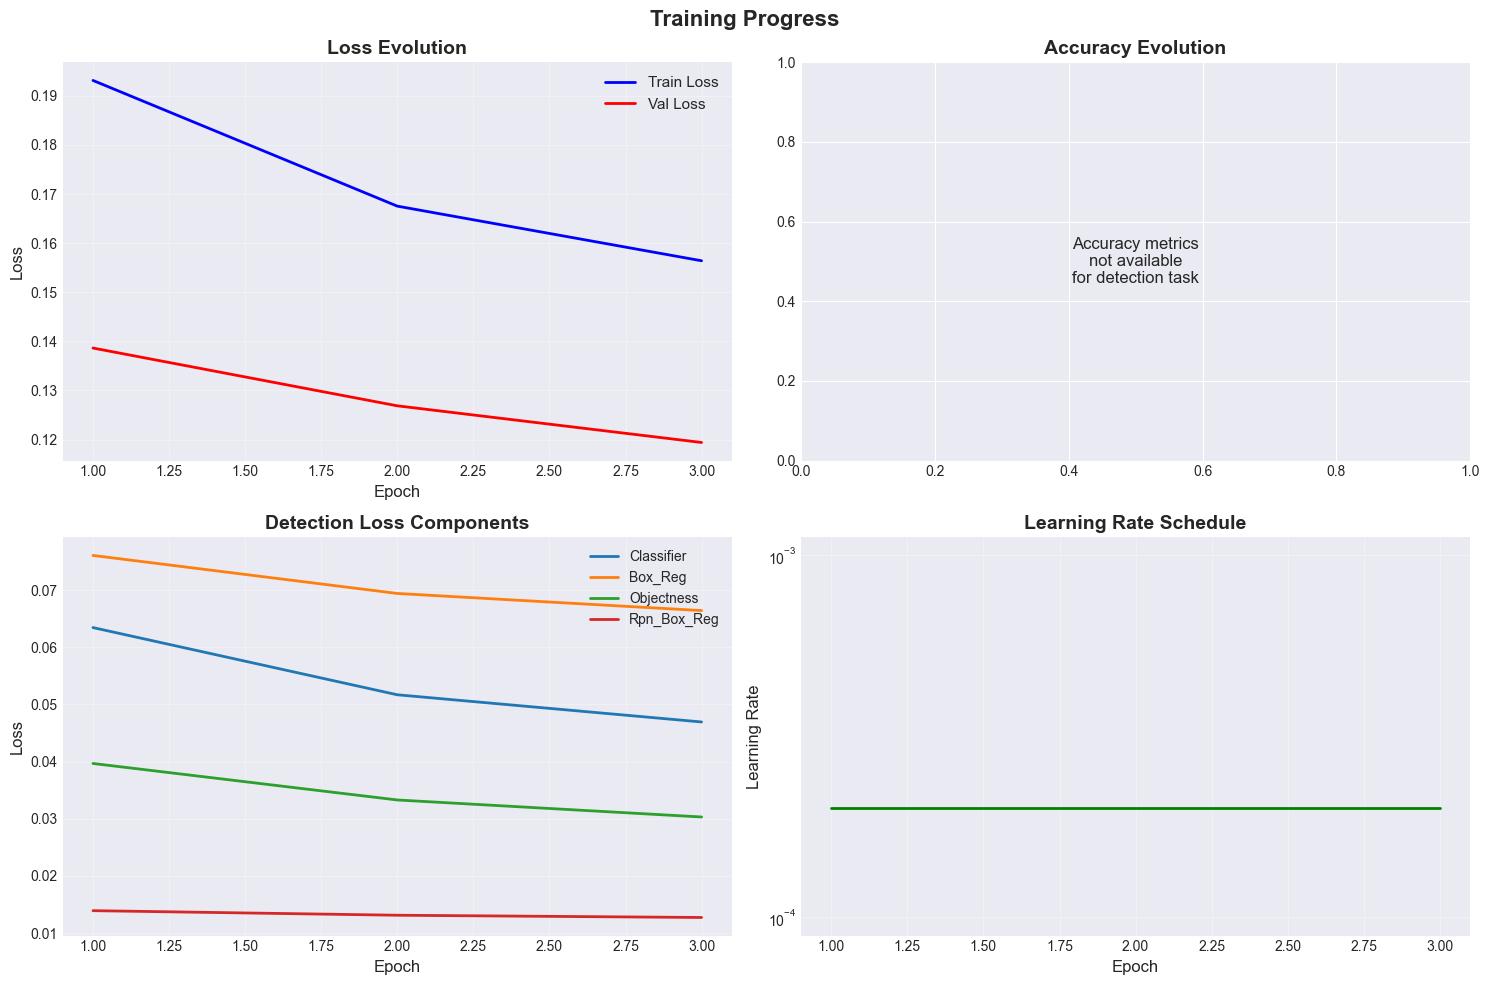

  Batch 100/13375, Loss: 0.1294
  Batch 200/13375, Loss: 0.3207
  Batch 300/13375, Loss: 0.1360
  Batch 400/13375, Loss: 0.0916
  Batch 500/13375, Loss: 0.0672
  Batch 600/13375, Loss: 0.0585
  Batch 700/13375, Loss: 1.3871
  Batch 800/13375, Loss: 0.1034
  Batch 900/13375, Loss: 0.1596
  Batch 1000/13375, Loss: 0.1087
  Batch 1100/13375, Loss: 0.1570
  Batch 1200/13375, Loss: 0.1553
  Batch 1300/13375, Loss: 0.1508
  Batch 1400/13375, Loss: 0.0761
  Batch 1500/13375, Loss: 0.1280
  Batch 1600/13375, Loss: 0.1389
  Batch 1700/13375, Loss: 0.1234
  Batch 1800/13375, Loss: 0.0885
  Batch 1900/13375, Loss: 0.1234
  Batch 2000/13375, Loss: 0.1171
  Batch 2100/13375, Loss: 0.1035
  Batch 2200/13375, Loss: 0.1513
  Batch 2300/13375, Loss: 0.0738
  Batch 2400/13375, Loss: 0.1281
  Batch 2500/13375, Loss: 0.1363
  Batch 2600/13375, Loss: 0.0840
  Batch 2700/13375, Loss: 0.0552
  Batch 2800/13375, Loss: 0.1665
  Batch 2900/13375, Loss: 0.2291
  Batch 3000/13375, Loss: 0.1191
  Batch 3100/13375,

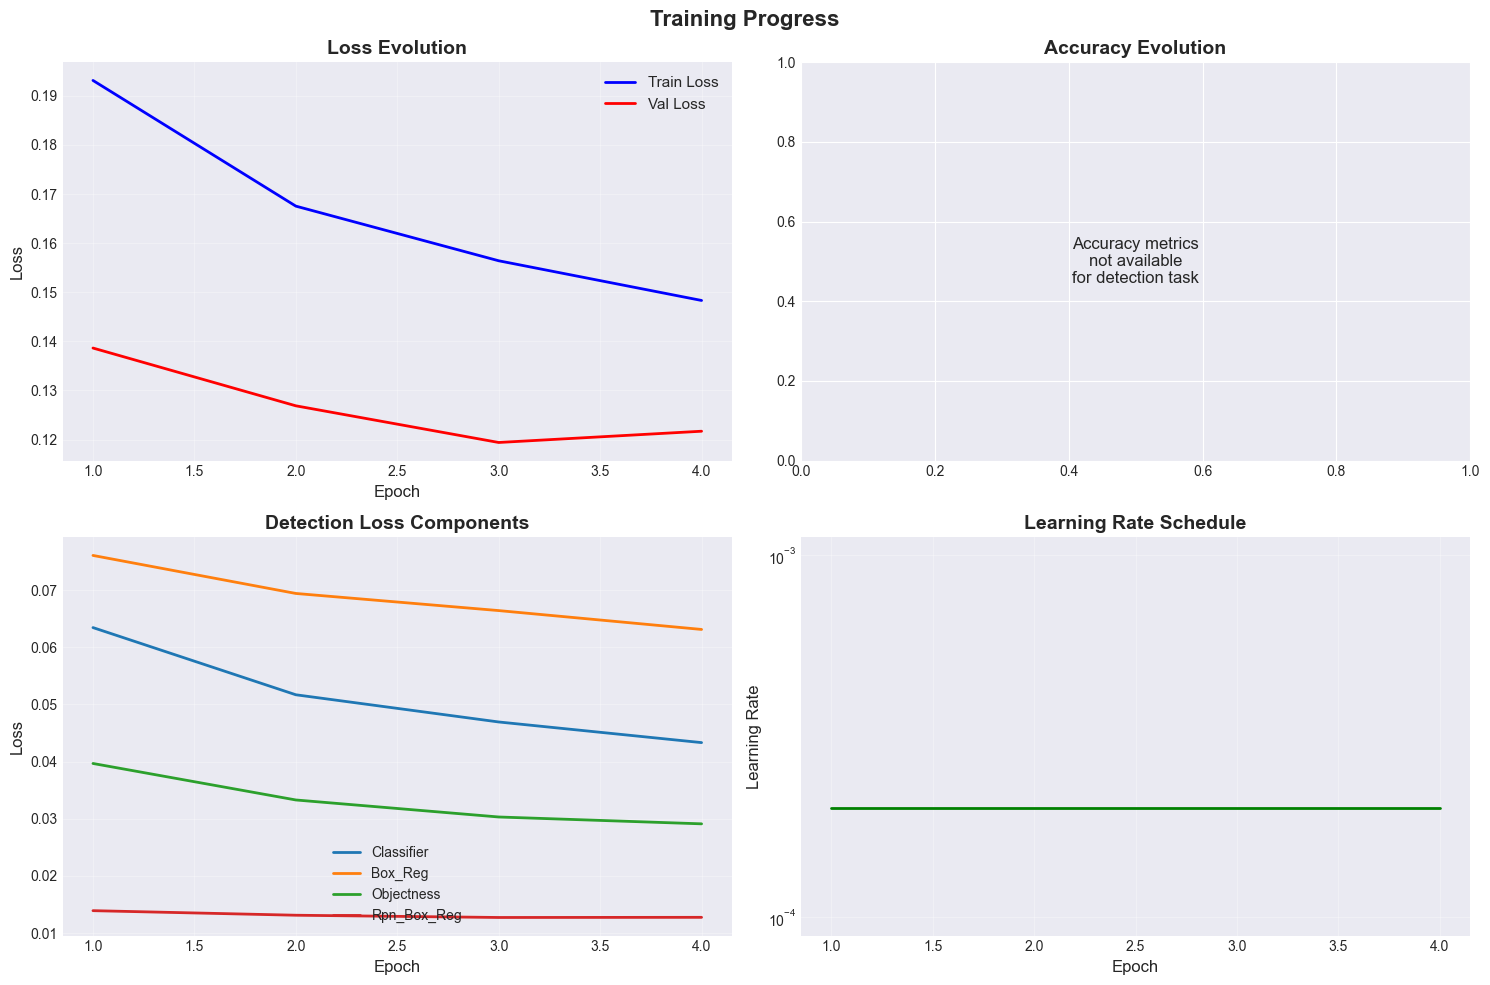

  Batch 100/13375, Loss: 0.0978
  Batch 200/13375, Loss: 0.0994
  Batch 300/13375, Loss: 0.0804
  Batch 400/13375, Loss: 0.1282
  Batch 500/13375, Loss: 0.1351
  Batch 600/13375, Loss: 0.1492
  Batch 700/13375, Loss: 0.0992
  Batch 800/13375, Loss: 0.1608
  Batch 900/13375, Loss: 0.1373
  Batch 1000/13375, Loss: 0.1437
  Batch 1100/13375, Loss: 0.1484
  Batch 1200/13375, Loss: 0.1011
  Batch 1300/13375, Loss: 0.0643
  Batch 1400/13375, Loss: 0.1016
  Batch 1500/13375, Loss: 0.0981
  Batch 1600/13375, Loss: 0.2072
  Batch 1700/13375, Loss: 0.1062
  Batch 1800/13375, Loss: 0.7219
  Batch 1900/13375, Loss: 0.1415
  Batch 2000/13375, Loss: 0.1047
  Batch 2100/13375, Loss: 0.0873
  Batch 2200/13375, Loss: 0.1221
  Batch 2300/13375, Loss: 0.1045
  Batch 2400/13375, Loss: 0.0663
  Batch 2500/13375, Loss: 0.0919
  Batch 2600/13375, Loss: 0.0594
  Batch 2700/13375, Loss: 0.0914
  Batch 2800/13375, Loss: 0.0694
  Batch 2900/13375, Loss: 0.0661
  Batch 3000/13375, Loss: 0.0667
  Batch 3100/13375,

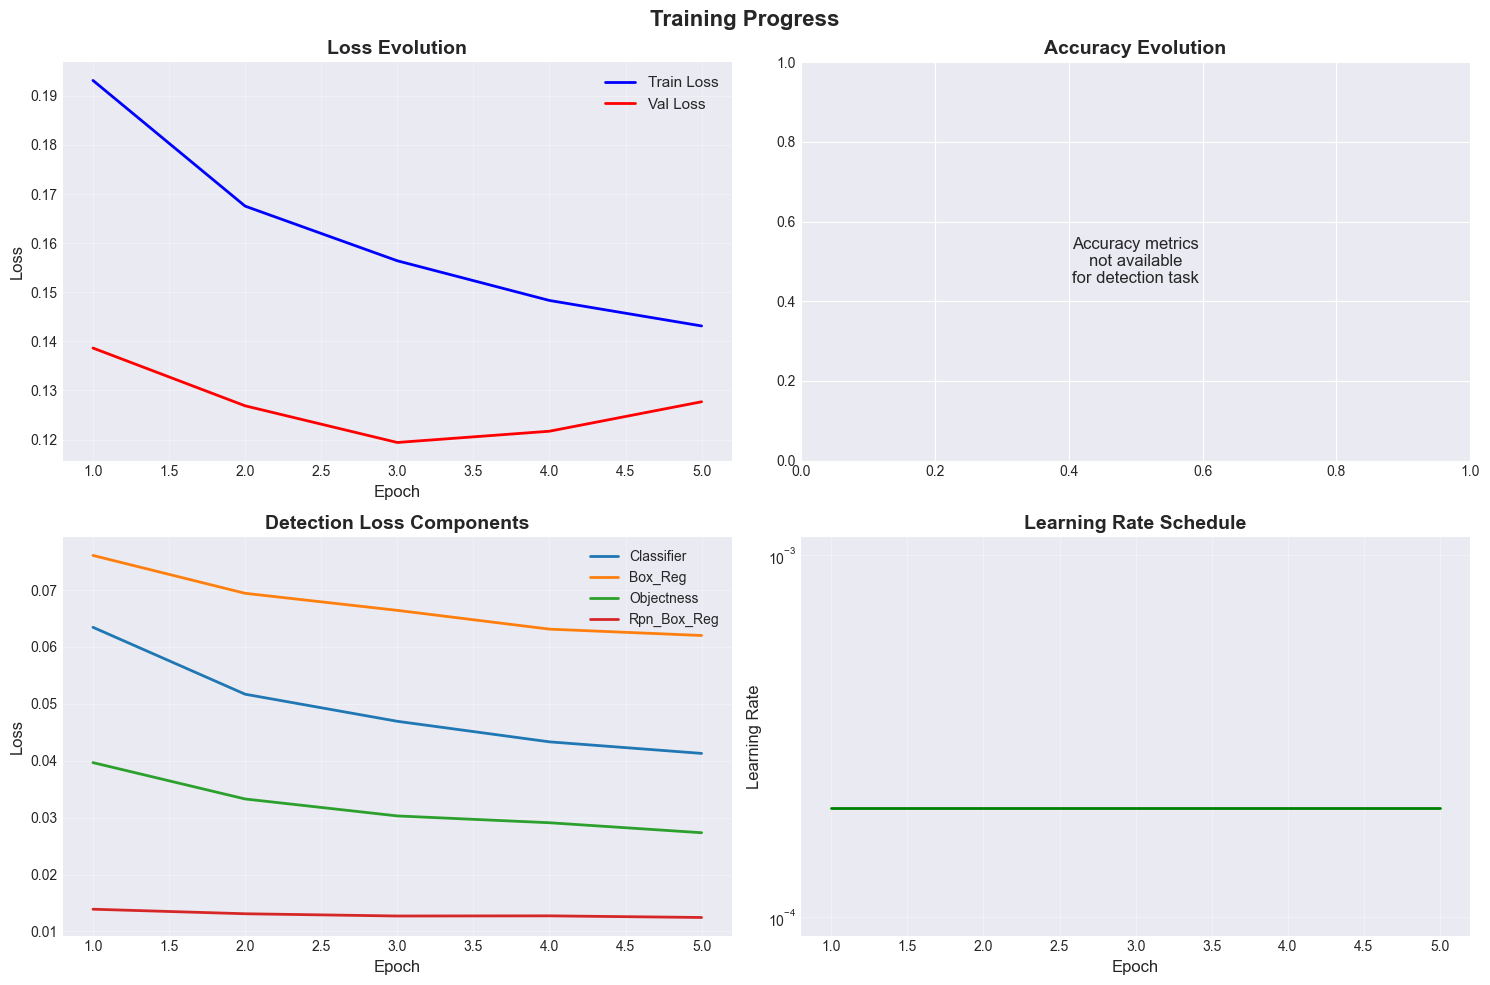

Saved training curves to runs\detector\training_curves_final.png


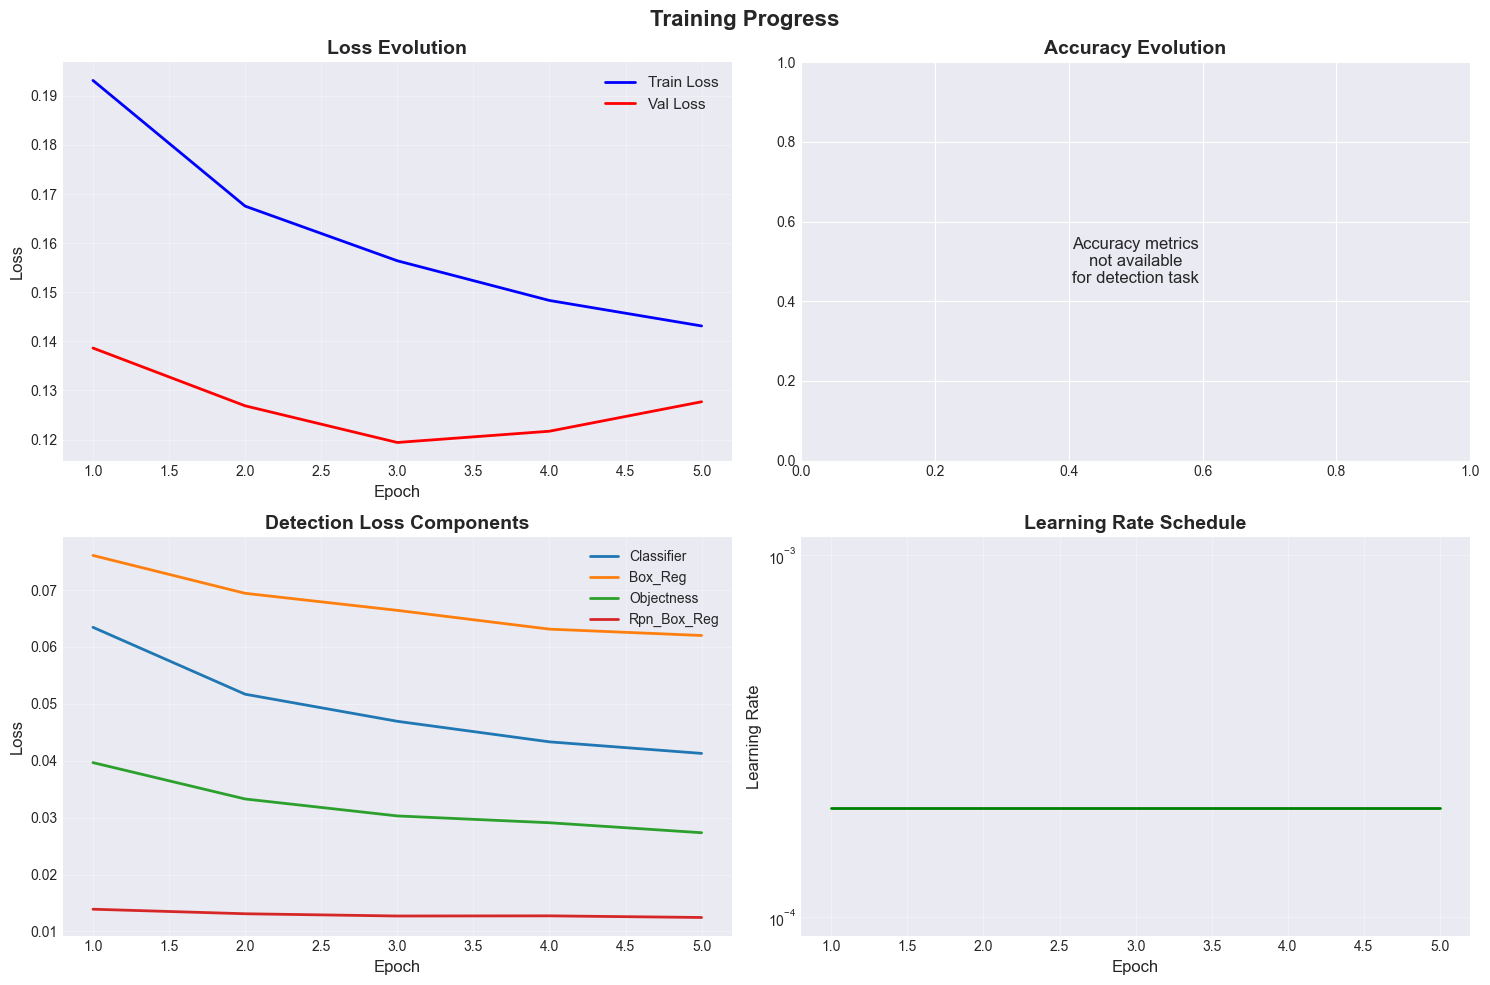


Training completed!
Final train loss: 0.1431
Final val loss: 0.1277


In [10]:
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from collections import defaultdict

# Set up matplotlib for inline plotting
%matplotlib inline
# Try different style options for compatibility
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        plt.style.use('ggplot')

def plot_training_curves(history, save_path=None):
    """Plot training curves for loss and accuracy/metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training Progress', fontsize=16, fontweight='bold')
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot 1: Loss curves
    ax1 = axes[0, 0]
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    if 'val_loss' in history and len(history['val_loss']) > 0 and len(history['val_loss']) == len(epochs):
        ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Loss Evolution', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Accuracy curves (for classification)
    ax2 = axes[0, 1]
    if 'train_acc' in history and len(history['train_acc']) > 0 and len(history['train_acc']) == len(epochs):
        ax2.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
        if 'val_acc' in history and len(history['val_acc']) > 0 and len(history['val_acc']) == len(epochs):
            ax2.plot(epochs, history['val_acc'], 'r-', label='Val Accuracy', linewidth=2)
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Accuracy', fontsize=12)
        ax2.set_title('Accuracy Evolution', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'Accuracy metrics\nnot available\nfor detection task', 
                ha='center', va='center', fontsize=12, transform=ax2.transAxes)
        ax2.set_title('Accuracy Evolution', fontsize=14, fontweight='bold')
    
    # Plot 3: Detection loss components (for detection task)
    ax3 = axes[1, 0]
    if 'loss_components' in history and history['loss_components']:
        loss_comp = history['loss_components']
        has_components = False
        for comp_name, values in loss_comp.items():
            if values and len(values) == len(epochs):  # Check if list is not empty and matches epochs
                ax3.plot(epochs, values, label=comp_name.replace('loss_', '').title(), linewidth=2)
                has_components = True
        if has_components:
            ax3.set_xlabel('Epoch', fontsize=12)
            ax3.set_ylabel('Loss', fontsize=12)
            ax3.set_title('Detection Loss Components', fontsize=14, fontweight='bold')
            ax3.legend(fontsize=10)
            ax3.grid(True, alpha=0.3)
        else:
            ax3.text(0.5, 0.5, 'Loss components\nnot tracked yet', 
                    ha='center', va='center', fontsize=12, transform=ax3.transAxes)
            ax3.set_title('Loss Components', fontsize=14, fontweight='bold')
    else:
        ax3.text(0.5, 0.5, 'Loss components\nnot tracked', 
                ha='center', va='center', fontsize=12, transform=ax3.transAxes)
        ax3.set_title('Loss Components', fontsize=14, fontweight='bold')
    
    # Plot 4: Learning rate (if tracked)
    ax4 = axes[1, 1]
    if 'learning_rate' in history and len(history['learning_rate']) > 0 and len(history['learning_rate']) == len(epochs):
        ax4.plot(epochs, history['learning_rate'], 'g-', linewidth=2)
        ax4.set_xlabel('Epoch', fontsize=12)
        ax4.set_ylabel('Learning Rate', fontsize=12)
        ax4.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        ax4.set_yscale('log')
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'Learning rate\nnot tracked yet', 
                ha='center', va='center', fontsize=12, transform=ax4.transAxes)
        ax4.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved training curves to {save_path}")
    
    plt.show()


def train_and_validate(model, train_loader, val_loader, config, device):
    task = config['task']
    epochs = config['train']['epochs']
    lr = config['train']['lr']
    weight_decay = config['train']['weight_decay']
    grad_clip = config['train'].get('grad_clip', None)
    
    # Initialize history tracking
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'loss_components': defaultdict(list),
        'learning_rate': []
    }
    
    # Create output directory for plots
    output_dir = Path(config['train'].get('checkpoint_dir', 'runs/detector'))
    output_dir.mkdir(parents=True, exist_ok=True)

    if task == 'classification':
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        
        for epoch in range(1, epochs + 1):
            model.train()
            total_loss = correct = total = 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                if grad_clip:
                    clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()

                total_loss += loss.item() * images.size(0)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            train_loss = total_loss / total
            train_acc = correct / total
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['learning_rate'].append(optimizer.param_groups[0]['lr'])

            # validation
            model.eval()
            v_loss = v_correct = v_total = 0
            y_true, y_pred = [], []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    v_loss += loss.item() * images.size(0)
                    preds = outputs.argmax(dim=1)
                    v_correct += (preds == labels).sum().item()
                    v_total += labels.size(0)
                    y_true.extend(labels.cpu().tolist())
                    y_pred.extend(preds.cpu().tolist())
            val_loss = v_loss / v_total
            val_acc = v_correct / v_total
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            print(f"Epoch {epoch}/{epochs}: train_loss={train_loss:.4f} train_acc={train_acc:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}")
            
            # Update plots every epoch
            if epoch % 1 == 0:  # Update every epoch
                plot_training_curves(history, save_path=output_dir / f'training_curves_epoch_{epoch}.png')

        print("\n" + "="*60)
        print("Final Classification Report:")
        print("="*60)
        print(classification_report(y_true, y_pred, target_names=config['data']['labels']))
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_true, y_pred))
        
        # Final plot
        plot_training_curves(history, save_path=output_dir / 'training_curves_final.png')

    else:  # detection
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = optim.AdamW(params, lr=lr, weight_decay=weight_decay)
        
        for epoch in range(1, epochs + 1):
            model.train()
            running_loss = 0.0
            epoch_loss_components = defaultdict(float)
            num_batches = 0
            
            for batch_idx, (images, targets) in enumerate(train_loader):
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                optimizer.zero_grad()
                loss_dict = model(images, targets)
                loss = sum(loss for loss in loss_dict.values())
                loss.backward()
                if grad_clip:
                    clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()
                
                running_loss += loss.item()
                for key, value in loss_dict.items():
                    epoch_loss_components[key] += value.item()
                num_batches += 1
                
                # Print progress every 100 batches
                if (batch_idx + 1) % 100 == 0:
                    print(f"  Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")

            avg_train_loss = running_loss / len(train_loader)
            history['train_loss'].append(avg_train_loss)
            
            # Store loss components
            for key, value in epoch_loss_components.items():
                history['loss_components'][key].append(value / num_batches)
            
            history['learning_rate'].append(optimizer.param_groups[0]['lr'])

            # validation
            val_loss = 0.0
            val_loss_components = defaultdict(float)
            val_batches = 0
            model.train()  # Set to train mode to get losses (even during validation)
            with torch.no_grad():
                for images, targets in val_loader:
                    images = [img.to(device) for img in images]
                    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                    loss_dict = model(images, targets)
                    
                    # Ensure loss_dict is a dictionary, not a list
                    if isinstance(loss_dict, list):
                        # If model returns predictions instead of losses, skip this batch
                        print(f"Warning: Model returned list instead of dict, skipping batch")
                        continue
                    
                    if not isinstance(loss_dict, dict):
                        print(f"Warning: Unexpected return type {type(loss_dict)}, skipping batch")
                        continue
                    
                    loss = sum(loss for loss in loss_dict.values())
                    val_loss += loss.item()
                    for key, value in loss_dict.items():
                        val_loss_components[key] += value.item()
                    val_batches += 1

            if val_batches > 0:
                avg_val_loss = val_loss / val_batches
                history['val_loss'].append(avg_val_loss)
                
                # Print detailed loss breakdown
                loss_str = ", ".join([f"{k}={v/val_batches:.4f}" for k, v in val_loss_components.items()])
                print(f"Epoch {epoch}/{epochs}: train_loss={avg_train_loss:.4f}, val_loss={avg_val_loss:.4f}")
                print(f"  Val loss components: {loss_str}")
            else:
                print(f"Warning: No valid validation batches processed in epoch {epoch}")
                history['val_loss'].append(0.0)
            
            # Update plots every epoch
            if epoch % 1 == 0:  # Update every epoch
                plot_training_curves(history, save_path=output_dir / f'training_curves_epoch_{epoch}.png')
        
        # Final plot
        plot_training_curves(history, save_path=output_dir / 'training_curves_final.png')
        
        print("\n" + "="*60)
        print("Training completed!")
        print("="*60)
        print(f"Final train loss: {history['train_loss'][-1]:.4f}")
        print(f"Final val loss: {history['val_loss'][-1]:.4f}")
    
    return history


history = train_and_validate(model, train_loader, val_loader, config, device)



## 5.1. Visualization Helpers

Helper functions to visualize training progress and model predictions.


Visualization helpers loaded!


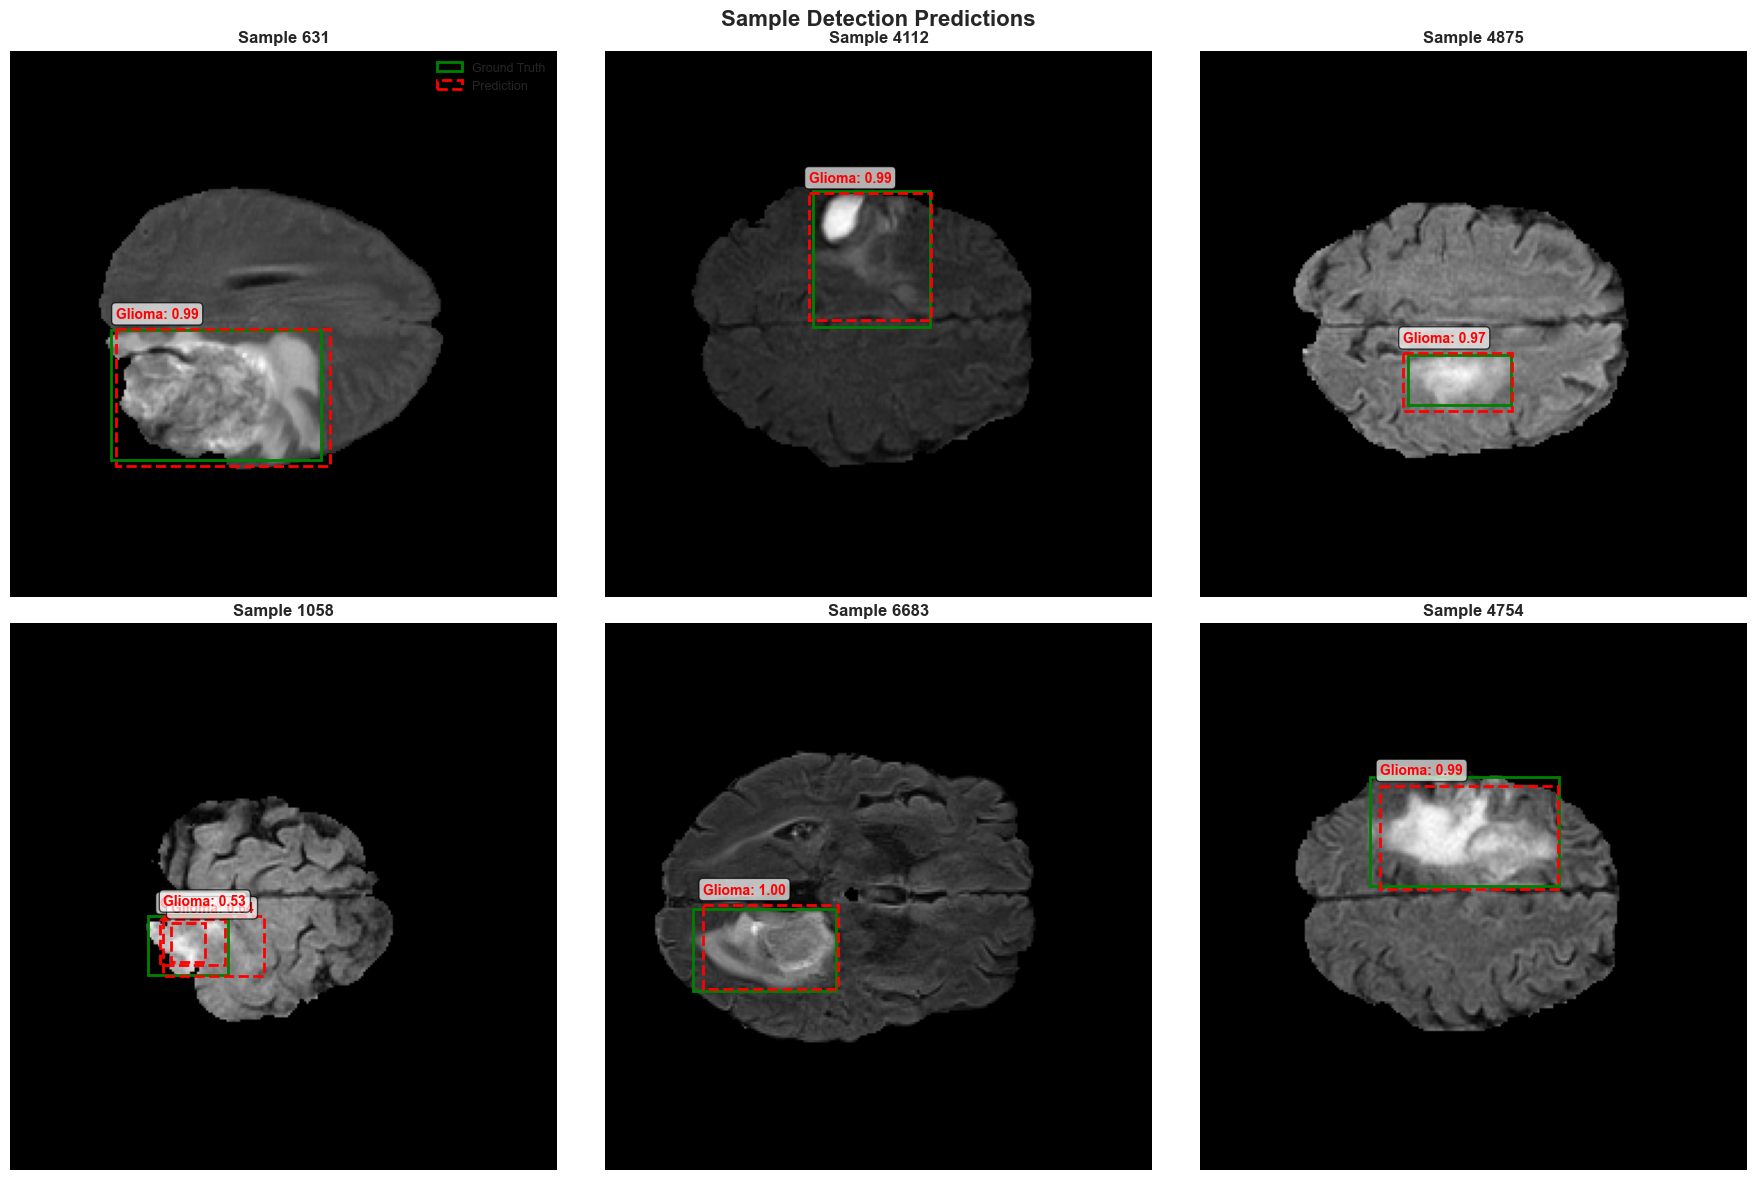

In [25]:
def visualize_detections(model, dataset, config, device, num_samples=6, threshold=0.5):
    """Visualize model predictions on validation samples"""
    model.eval()
    
    # Get random samples from dataset
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Sample Detection Predictions', fontsize=16, fontweight='bold')
    axes = axes.flatten()
    
    with torch.no_grad():
        for idx, ax in zip(indices, axes):
            image, target = dataset[idx]
            
            # Get prediction - model expects list of 3D tensors [C, H, W]
            img_tensor = image.to(device)
            outputs = model([img_tensor])[0]
            
            # Convert image tensor to numpy for display
            img_np = image.permute(1, 2, 0).cpu().numpy()
            img_np = np.clip(img_np, 0, 1)
            
            ax.imshow(img_np, cmap='gray' if img_np.shape[2] == 1 else None)
            ax.set_title(f'Sample {idx}', fontsize=12, fontweight='bold')
            ax.axis('off')
            
            # Draw ground truth boxes
            gt_boxes = target['boxes'].cpu().numpy()
            for box in gt_boxes:
                x1, y1, x2, y2 = box
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                    fill=False, color='green', linewidth=2, label='Ground Truth')
                ax.add_patch(rect)
            
            # Draw predicted boxes
            pred_boxes = outputs['boxes'].cpu().numpy()
            pred_scores = outputs['scores'].cpu().numpy()
            pred_labels = outputs['labels'].cpu().numpy()
            
            for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
                if score >= threshold:
                    x1, y1, x2, y2 = box
                    label_name = config['data']['labels'][label]
                    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                        fill=False, color='red', linewidth=2, linestyle='--')
                    ax.add_patch(rect)
                    ax.text(x1, y1-5, f'{label_name}: {score:.2f}', 
                           color='red', fontsize=10, fontweight='bold',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
            
            # Add legend only to first subplot
            if idx == indices[0]:
                from matplotlib.patches import Patch
                legend_elements = [
                    Patch(facecolor='none', edgecolor='green', linewidth=2, label='Ground Truth'),
                    Patch(facecolor='none', edgecolor='red', linewidth=2, linestyle='--', label='Prediction')
                ]
                ax.legend(handles=legend_elements, loc='upper right', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    model.train()  # Set back to training mode


def plot_confusion_matrix_heatmap(y_true, y_pred, labels, save_path=None):
    """Plot confusion matrix as a heatmap"""
    from sklearn.metrics import confusion_matrix
    
    try:
        import seaborn as sns
        use_seaborn = True
    except ImportError:
        use_seaborn = False
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    if use_seaborn:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=labels, yticklabels=labels,
                    cbar_kws={'label': 'Count'})
    else:
        # Fallback to matplotlib if seaborn not available
        plt.imshow(cm, interpolation='nearest', cmap='Blues')
        plt.colorbar(label='Count')
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, rotation=45)
        plt.yticks(tick_marks, labels)
        for i in range(len(labels)):
            for j in range(len(labels)):
                plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontweight='bold')
    
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved confusion matrix to {save_path}")
    
    plt.show()

print("Visualization helpers loaded!")

# Visualize detection predictions
visualize_detections(model, val_ds, config, device, num_samples=6)

# Note: Confusion matrix is for classification tasks only
# Usage: plot_confusion_matrix_heatmap(y_true, y_pred, config['data']['labels'])


## 6. Save checkpoint


In [26]:
## 7.0. Convert data to YOLO format

import json
import shutil
from pathlib import Path
from PIL import Image

# Paths
yolo_root = root / "data/yolo"
yolo_root.mkdir(parents=True, exist_ok=True)

# Create YOLO directory structure
(yolo_root / "images" / "train").mkdir(parents=True, exist_ok=True)
(yolo_root / "images" / "val").mkdir(parents=True, exist_ok=True)
(yolo_root / "labels" / "train").mkdir(parents=True, exist_ok=True)
(yolo_root / "labels" / "val").mkdir(parents=True, exist_ok=True)

# Load annotations
with open(train_annotations, 'r') as f:
    train_samples = json.load(f)
with open(val_annotations, 'r') as f:
    val_samples = json.load(f)

# Class mapping (assuming single class "Glioma" = class 0)
class_to_id = {"Glioma": 0, "No Tumor": 0}  # Map all to class 0 for tumor detection
# If you have multiple classes, update this:
# class_to_id = {"Glioma": 0, "Meningioma": 1, "Pituitary": 2}

def convert_bbox_to_yolo(bbox, img_width, img_height):
    """Convert [x1, y1, x2, y2] to YOLO format [class_id, x_center, y_center, width, height] (normalized)"""
    x1, y1, x2, y2 = bbox
    
    # Calculate center and dimensions
    x_center = (x1 + x2) / 2.0
    y_center = (y1 + y2) / 2.0
    width = x2 - x1
    height = y2 - y1
    
    # Normalize
    x_center /= img_width
    y_center /= img_height
    width /= img_width
    height /= img_height
    
    return x_center, y_center, width, height

def convert_samples(samples, split_name, image_root, yolo_image_dir, yolo_label_dir):
    """Convert samples to YOLO format"""
    converted = 0
    skipped = 0
    
    for sample in samples:
        img_name = sample["image"]
        img_path = image_root / img_name
        
        if not img_path.exists():
            skipped += 1
            continue
        
        # Get image dimensions
        img = Image.open(img_path)
        img_width, img_height = img.size
        
        # Copy image to YOLO directory
        shutil.copy2(img_path, yolo_image_dir / img_name)
        
        # Create label file
        label_name = Path(img_name).stem + ".txt"
        label_path = yolo_label_dir / label_name
        
        # Convert bbox to YOLO format
        bbox = sample.get("bbox", [])
        if bbox and len(bbox) == 4:
            class_id = class_to_id.get(sample.get("label", "Glioma"), 0)
            x_center, y_center, width, height = convert_bbox_to_yolo(bbox, img_width, img_height)
            
            # Write YOLO format label file
            with open(label_path, 'w') as f:
                f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
            converted += 1
        else:
            # No bbox, create empty label file
            label_path.touch()
            skipped += 1
    
    return converted, skipped

# Convert train and val sets
print("Converting training set...")
train_conv, train_skip = convert_samples(
    train_samples, "train", 
    Path(config["data"]["image_root"]),
    yolo_root / "images" / "train",
    yolo_root / "labels" / "train"
)

print("Converting validation set...")
val_conv, val_skip = convert_samples(
    val_samples, "val",
    Path(config["data"]["image_root"]),
    yolo_root / "images" / "val",
    yolo_root / "labels" / "val"
)

print(f"\nConversion complete!")
print(f"Train: {train_conv} converted, {train_skip} skipped")
print(f"Val: {val_conv} converted, {val_skip} skipped")
print(f"YOLO dataset location: {yolo_root}")


Converting training set...
Converting validation set...

Conversion complete!
Train: 26750 converted, 0 skipped
Val: 6688 converted, 0 skipped
YOLO dataset location: C:\Users\FERRA\OneDrive\Documents\github\BT-pipe\data\yolo


In [27]:
from pathlib import Path

def save_checkpoint(model, path="runs/detector/completed.pt"):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    torch.save(model.state_dict(), path)
    print(f"Saved {path}")

save_checkpoint(model)

Saved runs/detector/completed.pt


## 7. YOLOv8 (optional detection)
Requires images/labels in YOLO format and `ultralytics` installed.


In [29]:
# Build YOLO data yaml (adjust paths/names)
import yaml

yolo_data = {
    "path": str(root / "data/yolo"),  # absolute path to YOLO data root
    "train": "images/train",
    "val": "images/val",
    "names": {0: "Tumor"},     # change if multiple classes
}

with open("configs/yolo_task01.yaml", "w", encoding="utf-8") as f:
    yaml.safe_dump(yolo_data, f)
print("Wrote configs/yolo_task01.yaml")

# Example training (uncomment when data ready)
from ultralytics import YOLO
yolo_model = YOLO("yolov8n.pt")
yolo_model.train(data="configs/yolo_task01.yaml", epochs=20, imgsz=640, batch=8, project="runs/yolo", name="task01")
yolo_model.val(data="configs/yolo_task01.yaml")

Wrote configs/yolo_task01.yaml
Ultralytics 8.3.237  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=configs/yolo_task01.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=task012, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tru

c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setD

AMP: checks passed 
train: Fast image access  (ping: 0.20.2 ms, read: 0.90.3 MB/s, size: 11.5 KB)
train: Scanning C:\Users\FERRA\OneDrive\Documents\github\BT-pipe\Data\yolo\labels\train... 26750 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 26750/26750 385.5it/s 1:09<0.1ss
train: New cache created: C:\Users\FERRA\OneDrive\Documents\github\BT-pipe\Data\yolo\labels\train.cache
val: Fast image access  (ping: 0.10.1 ms, read: 0.60.3 MB/s, size: 10.9 KB)
val: Scanning C:\Users\FERRA\OneDrive\Documents\github\BT-pipe\Data\yolo\labels\val... 6688 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 6688/6688 311.4it/s 21.5s<0.0s
val: New cache created: C:\Users\FERRA\OneDrive\Documents\github\BT-pipe\Data\yolo\labels\val.cache
Plotting labels to C:\Users\FERRA\OneDrive\Documents\github\BT-pipe\notebooks\runs\yolo\task012\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optim

c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       1/20      2.13G      1.511      1.651      1.457          6        640: 100% ━━━━━━━━━━━━ 3344/3344 5.8it/s 9:38<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 418/418 6.6it/s 1:03<0.2ss
                   all       6688       6688      0.815      0.691      0.775      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/20      2.13G      1.447      1.183      1.564         10        640: 0% ──────────── 0/3344  0.4s

c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       2/20      2.13G      1.418       1.19      1.408          6        640: 100% ━━━━━━━━━━━━ 3344/3344 6.1it/s 9:05<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 418/418 7.6it/s 55.0s<0.1s
                   all       6688       6688      0.834      0.709      0.796      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/20      2.13G       1.57      1.442      1.498         15        640: 0% ──────────── 0/3344  0.1s

c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       3/20      2.13G      1.374      1.123      1.384         10        640: 100% ━━━━━━━━━━━━ 3344/3344 7.0it/s 7:60<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 418/418 7.3it/s 57.1s<0.1s
                   all       6688       6688      0.852       0.73      0.814      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/20      2.13G       1.58      1.142      1.366         12        640: 0% ──────────── 0/3344  0.2s

c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       4/20      2.13G       1.33      1.069      1.358          7        640: 100% ━━━━━━━━━━━━ 3344/3344 6.8it/s 8:14<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 418/418 7.4it/s 56.3s<0.1s
                   all       6688       6688      0.854      0.744      0.819      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/20      2.13G      1.588      1.179      1.256         16        640: 0% ──────────── 0/3344  0.2s

c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       5/20      2.14G       1.28      1.012      1.325         10        640: 100% ━━━━━━━━━━━━ 3344/3344 7.1it/s 7:50<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 418/418 7.6it/s 54.8s<0.1s
                   all       6688       6688      0.869      0.745      0.835      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/20      2.14G      1.491      1.065      1.337         15        640: 0% ──────────── 0/3344  0.2s

c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       6/20      2.14G      1.247     0.9688      1.309         10        640: 100% ━━━━━━━━━━━━ 3344/3344 7.1it/s 7:51<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 418/418 7.4it/s 56.3s<0.1s
                   all       6688       6688      0.876       0.76      0.845       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/20      2.14G      1.007     0.7448      1.244         15        640: 0% ──────────── 0/3344  0.2s

c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       7/20      2.14G      1.216     0.9383      1.293          7        640: 100% ━━━━━━━━━━━━ 3344/3344 7.4it/s 7:30<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 418/418 7.8it/s 53.6s<0.1s
                   all       6688       6688      0.896      0.766      0.851      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/20      2.14G     0.8679     0.7067      1.128         15        640: 0% ──────────── 0/3344  0.2s

c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       8/20      2.14G      1.195     0.9076      1.279         10        640: 100% ━━━━━━━━━━━━ 3344/3344 7.3it/s 7:38<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 418/418 7.8it/s 53.5s<0.1s
                   all       6688       6688       0.89      0.775      0.857      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/20      2.14G       1.19     0.6721      1.305         15        640: 0% ──────────── 0/3344  0.2s

c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       9/20      2.14G      1.179     0.8889      1.273         18        640: 100% ━━━━━━━━━━━━ 3344/3344 7.3it/s 7:39<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 418/418 7.8it/s 53.6s<0.1s
                   all       6688       6688      0.899       0.78      0.863      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/20      2.14G      1.156     0.9696      1.151         14        640: 0% ──────────── 0/3344  0.2s

c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      10/20      2.14G      1.159     0.8734      1.256          4        640: 100% ━━━━━━━━━━━━ 3344/3344 7.1it/s 7:48<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 418/418 7.8it/s 53.8s<0.1s
                   all       6688       6688      0.898      0.788      0.868      0.622
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      11/20      2.14G      1.083     0.7554      1.203          6        640: 100% ━━━━━━━━━━━━ 3344/3344 7.2it/s 7:45<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 418/418 7.2it/s 58.1s<0.1s
                   all       6688       6688      0.905      0.785      0.872      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/20      2.14G      1.228     0.8821      1.385          8        640: 0% ──────────── 0/3344  0.2s

c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      12/20      2.14G      1.053      0.719      1.188          6        640: 100% ━━━━━━━━━━━━ 3344/3344 7.4it/s 7:33<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 418/418 7.6it/s 55.0s<0.1s
                   all       6688       6688      0.906      0.794      0.878      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/20      2.14G      1.016     0.5887      1.115          8        640: 0% ──────────── 0/3344  0.2s

c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      13/20      2.14G       1.02     0.6879      1.162          6        640: 100% ━━━━━━━━━━━━ 3344/3344 7.4it/s 7:29<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 418/418 7.8it/s 53.9s<0.1s
                   all       6688       6688       0.91      0.801      0.885      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/20      2.14G      1.096     0.6126       1.11          8        640: 0% ──────────── 0/3344  0.2s

c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      14/20      2.14G      1.002     0.6661      1.148          6        640: 100% ━━━━━━━━━━━━ 3344/3344 7.3it/s 7:38<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 418/418 7.5it/s 55.9s<0.1s
                   all       6688       6688      0.916      0.805      0.889      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/20      2.14G     0.8985     0.4293      1.038          8        640: 0% ──────────── 0/3344  0.2s

c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      15/20      2.14G     0.9774      0.641      1.131          6        640: 100% ━━━━━━━━━━━━ 3344/3344 6.2it/s 9:00<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 418/418 6.3it/s 1:06<0.1ss
                   all       6688       6688       0.91      0.811      0.893      0.673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/20      2.14G     0.9466       1.02      1.142          8        640: 0% ──────────── 0/3344  0.2s

c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      16/20      2.14G     0.9536     0.6174      1.112          6        640: 100% ━━━━━━━━━━━━ 3344/3344 7.0it/s 7:58<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 418/418 7.7it/s 54.3s<0.1s
                   all       6688       6688      0.919      0.814      0.899      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/20      2.14G     0.7006     0.4868      1.051          8        640: 0% ──────────── 0/3344  0.2s

c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      17/20      2.14G      0.935     0.5983      1.101          6        640: 100% ━━━━━━━━━━━━ 3344/3344 7.4it/s 7:31<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 418/418 7.7it/s 54.1s<0.1s
                   all       6688       6688      0.916      0.827      0.903      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/20      2.14G      1.125     0.8353      1.073          8        640: 0% ──────────── 0/3344  0.2s

c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      18/20      2.14G     0.9174     0.5819      1.089          6        640: 100% ━━━━━━━━━━━━ 3344/3344 7.7it/s 7:16<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 418/418 7.8it/s 53.5s<0.1s
                   all       6688       6688      0.924      0.822      0.905      0.689

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/20      2.14G     0.8881     0.8683      1.137          8        640: 0% ──────────── 0/3344  0.2s

c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      19/20      2.14G     0.8947     0.5632      1.075          6        640: 100% ━━━━━━━━━━━━ 3344/3344 7.7it/s 7:14<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 418/418 7.4it/s 56.3s<0.1s
                   all       6688       6688      0.923      0.827      0.906      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/20      2.14G     0.8144     0.4612     0.9172          8        640: 0% ──────────── 0/3344  0.2s

c:\Users\FERRA\.conda\envs\dl\lib\site-packages\ultralytics\utils\loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      20/20      2.14G     0.8771      0.545      1.064          6        640: 100% ━━━━━━━━━━━━ 3344/3344 7.5it/s 7:26<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 418/418 7.8it/s 53.6s<0.1s
                   all       6688       6688      0.923      0.829      0.908      0.694

20 epochs completed in 2.960 hours.
Optimizer stripped from C:\Users\FERRA\OneDrive\Documents\github\BT-pipe\notebooks\runs\yolo\task012\weights\last.pt, 6.2MB
Optimizer stripped from C:\Users\FERRA\OneDrive\Documents\github\BT-pipe\notebooks\runs\yolo\task012\weights\best.pt, 6.2MB

Validating C:\Users\FERRA\OneDrive\Documents\github\BT-pipe\notebooks\runs\yolo\task012\weights\best.pt...
Ultralytics 8.3.237  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R     

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001EE68E66CB0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

## 8. Quick inference helper


Running inference on: C:\Users\FERRA\OneDrive\Documents\github\BT-pipe\data\processed\BRATS_001_z038.png
{'detections': [{'bbox': [114.45, 139.52, 151.92, 171.49], 'score': 0.9764, 'label': 'Glioma'}, {'bbox': [90.8, 68.53, 136.84, 100.79], 'score': 0.4293, 'label': 'Glioma'}, {'bbox': [115.18, 147.34, 140.02, 167.38], 'score': 0.3393, 'label': 'Glioma'}, {'bbox': [75.87, 137.48, 150.41, 171.13], 'score': 0.2139, 'label': 'Glioma'}, {'bbox': [122.3, 143.13, 145.52, 166.11], 'score': 0.1514, 'label': 'Glioma'}, {'bbox': [97.23, 143.86, 140.87, 165.65], 'score': 0.0533, 'label': 'Glioma'}]}
Showing 3 detections with confidence >= 0.3


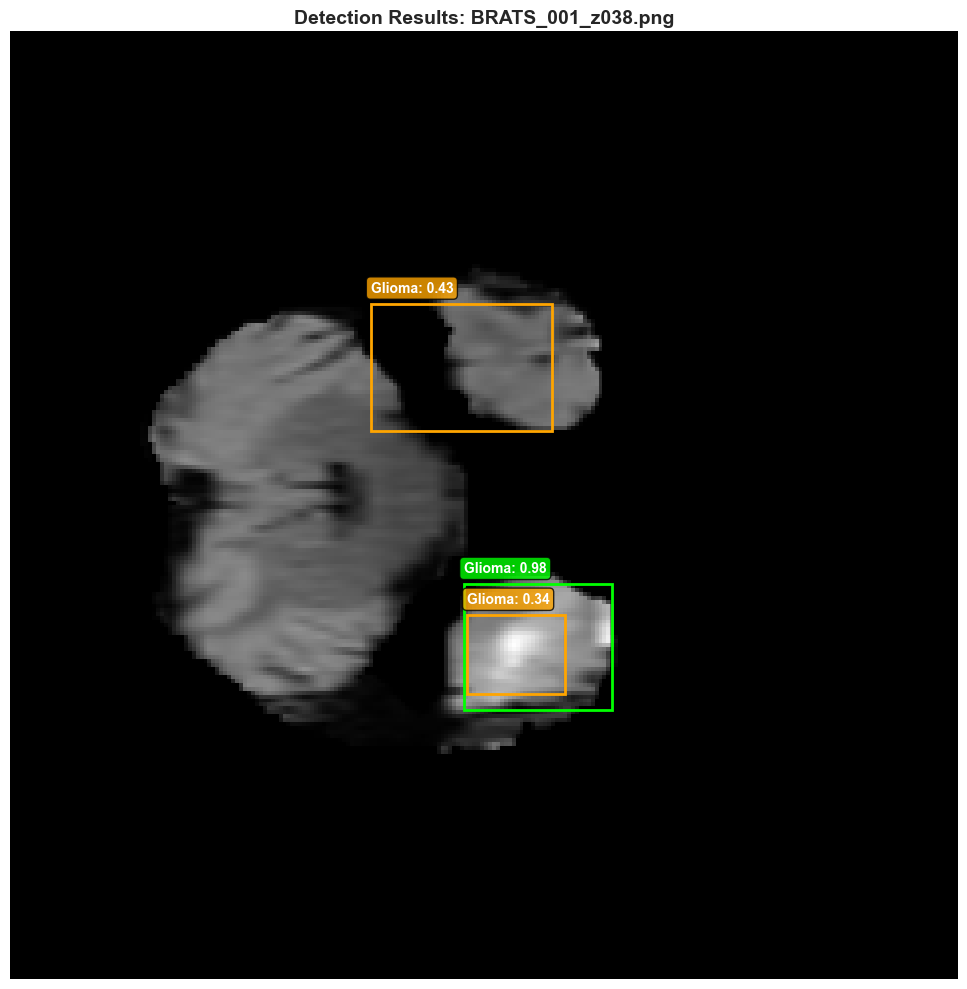

In [41]:
from PIL import Image
import torchvision.transforms as T

def infer_image(model, image_path, config, device):
    """Run inference on a single image"""
    model.eval()
    img = Image.open(image_path).convert('RGB')
    if config['task'] == 'classification':
        tfm = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        tensor = tfm(img).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = model(tensor)
            probs = torch.softmax(logits, dim=1)
            conf, pred = probs.max(dim=1)
        return {"label": config['data']['labels'][pred.item()], "confidence": conf.item()}
    else:
        tfm = T.Compose([T.ToTensor()])
        tensor = tfm(img).to(device)
        with torch.no_grad():
            outputs = model([tensor])[0]
        if len(outputs['boxes']) == 0:
            return {"detections": []}
        detections = []
        for b, s, l in zip(outputs['boxes'].cpu(), outputs['scores'].cpu(), outputs['labels'].cpu()):
            detections.append({
                "bbox": [round(x.item(), 2) for x in b],
                "score": round(float(s), 4),
                "label": config['data']['labels'][l],
            })
        return {"detections": detections}

def visualize_inference(image_path, result, threshold=0.3):
    """Display image with detected bounding boxes"""
    img = Image.open(image_path).convert('RGB')
    
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)
    ax.set_title(f'Detection Results: {Path(image_path).name}', fontsize=14, fontweight='bold')
    ax.axis('off')
    
    detections = result.get('detections', [])
    shown = 0
    
    for det in detections:
        score = det['score']
        if score < threshold:
            continue
        
        x1, y1, x2, y2 = det['bbox']
        label = det['label']
        
        # Color based on confidence
        color = 'lime' if score > 0.5 else 'orange' if score > 0.3 else 'red'
        
        # Draw bounding box
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                              linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        # Add label
        ax.text(x1, y1 - 3, f'{label}: {score:.2f}',
                color='white', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.8))
        shown += 1
    
    print(f"Showing {shown} detections with confidence >= {threshold}")
    plt.tight_layout()
    plt.show()

# Get sample images from the dataset
sample_images = list(Path(config['data']['image_root']).glob("*.png"))
if not sample_images:
    sample_images = list(Path(config['data']['image_root']).glob("*.jpg"))

# Run inference and visualize
if sample_images:
    sample_path = str(sample_images[9])
    print(f"Running inference on: {sample_path}")
    result = infer_image(model, sample_path, config, device)
    print(result)
    # Visualize the detection
    visualize_inference(sample_path, result, threshold=0.3)
else:
    print("No images found in image_root. Set a valid image path manually.")

